In [1]:
# import the libraries
import numpy as np
from glob import glob
#import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive')

# re-size all the images to this
IMAGE_SIZE = [224, 224]

imageTrainPath = '/content/drive/MyDrive/imagenette/imagenette2-160/train'

sample_fish_path = '/content/drive/MyDrive/imagenette/imagenette2-160/train/n01440764'
sample_dog_path = '/content/drive/MyDrive/imagenette/imagenette2-160/train/n02102040'

sample_fish_test_path = '/content/drive/MyDrive/imagenette/imagenette2-160/test/n01440764'
sample_dog_test_path = '/content/drive/MyDrive/imagenette/imagenette2-160/test/n02102040'





Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


1 a. Plot at least twosamplesfrom each class of the dataset

dog


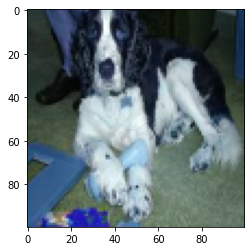

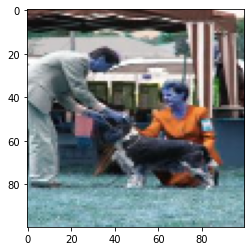

fish


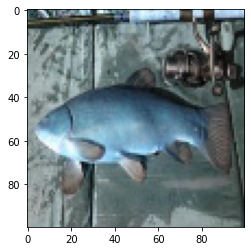

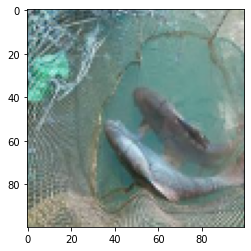

gas_station


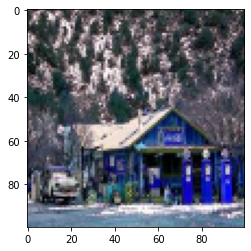

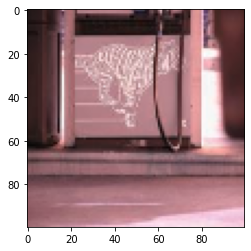

tape


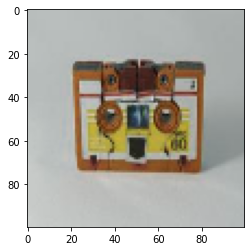

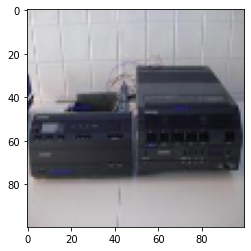

saw


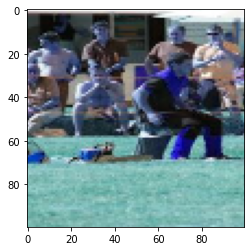

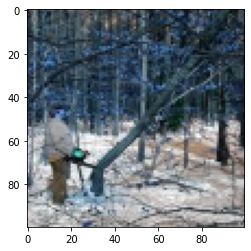

trumpet


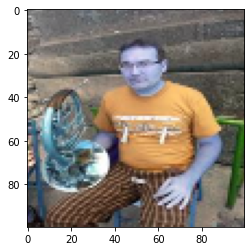

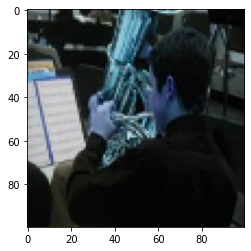

parachute


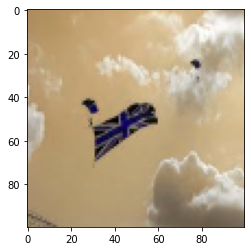

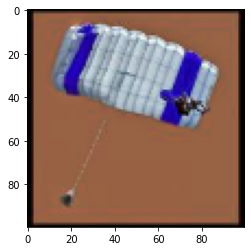

church


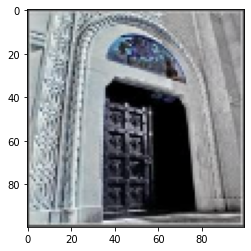

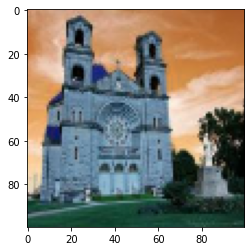

ball


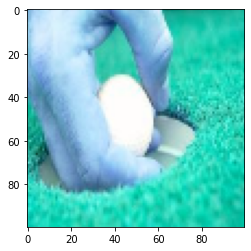

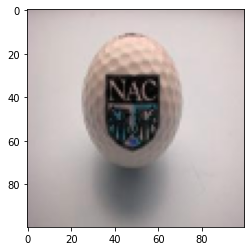

truck


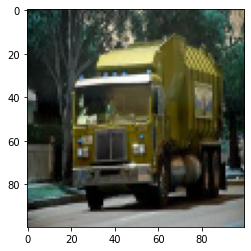

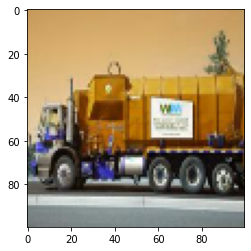

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import os

categories = ["n03888257", "n03445777", "n03425413", "n03417042", "n03394916", "n03028079", "n03000684", "n02979186", "n02102040", "n01440764"]
category_class = ["parachute", "ball", "gas_station", "truck", "trumpet", "church", "saw", "tape", "dog", "fish"] 
imageArray = []
IMG_SIZE = 100
c = 0
for root, dirs, files in os.walk(imageTrainPath):
    for dir in dirs:
       cl = category_class[categories.index(dir)]
       print(cl)
       for file in glob.glob(imageTrainPath + "/" + dir + "/*.JPEG"):
         image = cv2.resize(cv2.imread (file), (IMG_SIZE, IMG_SIZE))
         imageArray.append(image)
         plt.imshow(image)
         plt.show()
         c = c + 1
         if c == 2:
           break
       c = 0

1.b Apply rotation and height shift augmentation 

dog


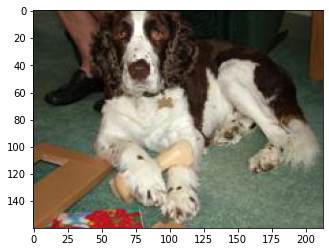

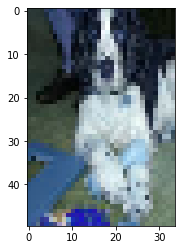

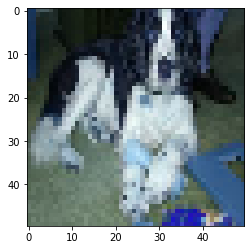

fish


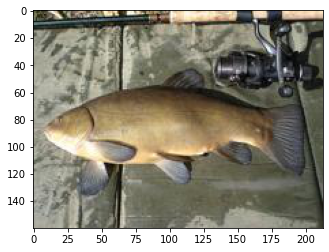

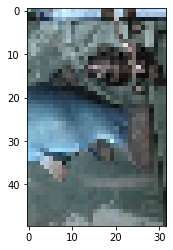

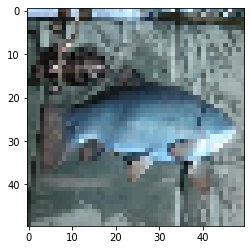

gas_station


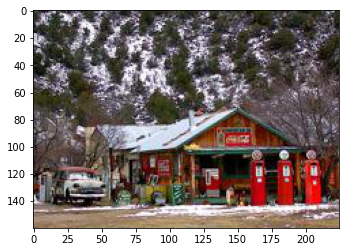

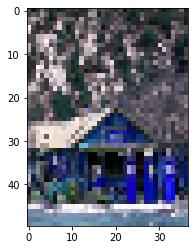

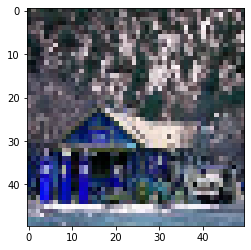

tape


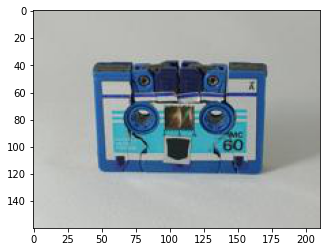

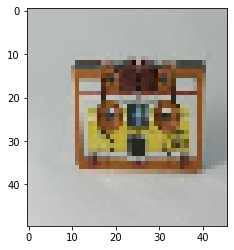

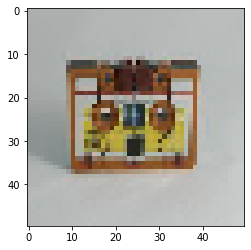

saw


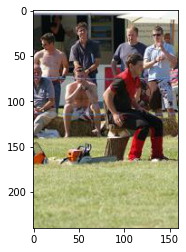

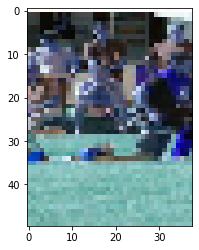

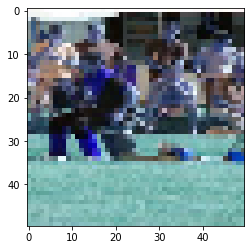

trumpet


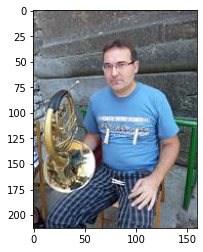

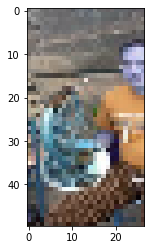

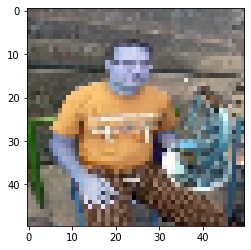

parachute


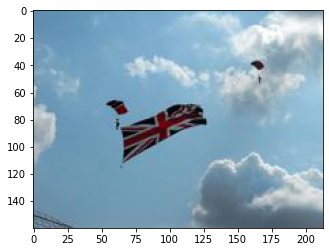

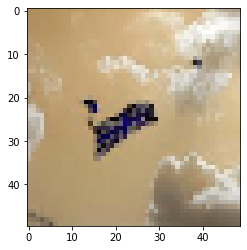

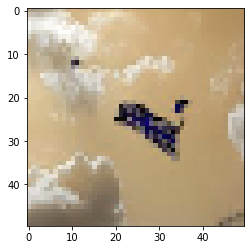

church


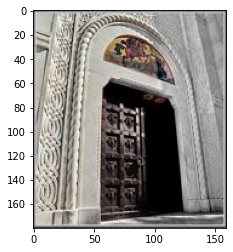

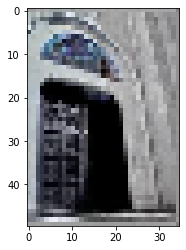

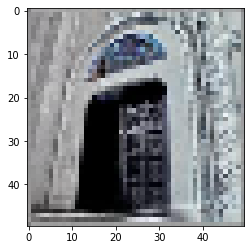

ball


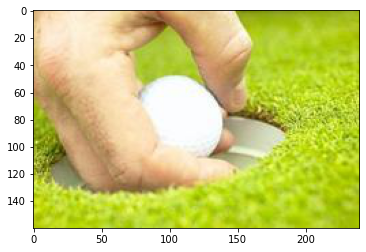

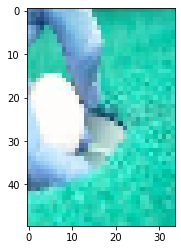

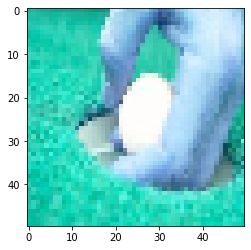

truck


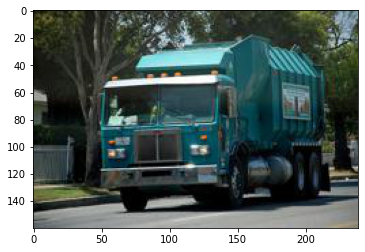

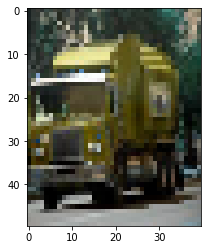

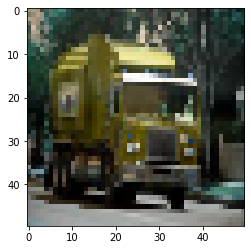

In [3]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import random

datagen = ImageDataGenerator(
    horizontal_flip=True,
    width_shift_range=0.2)

def rotate_and_height_shift():
  IMG_SIZE = 50
  for root, dirs, files in os.walk(imageTrainPath):
    for dir in dirs:
       cl = category_class[categories.index(dir)]
       print(cl)
       for file in glob.glob(imageTrainPath + "/" + dir + "/*.JPEG"):
         img = load_img(file)
         plt.imshow(img)
         plt.show()
         image = cv2.resize(cv2.imread (file), (IMG_SIZE, IMG_SIZE))
         plt.imshow(horizontal_shift(image, 0.5))
         plt.show()
         plt.imshow(cv2.flip(image, 1))
         plt.show()
         break


def horizontal_shift(img, ratio=0.0):
    if ratio > 1 or ratio < 0:
        print('Value should be less than 1 and greater than 0')
        return img
    ratio = random.uniform(-ratio, ratio)
    h, w = img.shape[:2]
    to_shift = w*ratio
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]
    return img


rotate_and_height_shift()

1.c Bring the train and test data in the required format.

In [4]:
training_data = []
c = 0
def craete_training_data():
  for root, dirs, files in os.walk(imageTrainPath):
    for dir in dirs:
       cl = category_class[categories.index(dir)]
       print(cl)
       for file in glob.glob(imageTrainPath + "/" + dir + "/*.JPEG"):
         try:
            img_array = cv2.imread(file, cv2.IMREAD_GRAYSCALE)
            image = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            training_data.append([image, categories.index(dir)])
            
         except Exception as e:
            pass

craete_training_data()



dog
fish
gas_station
tape
saw
trumpet
parachute
church
ball
truck


Shuffle the dataset

In [5]:
print(len(training_data))

import random
def shuffle_data(data):
  random.shuffle(data)


shuffle_data(training_data)

print(training_data[1][1])

9469
5


1.c prepare the train and test data in required format

In [6]:
X = []
y = []

print(len(training_data))
for features, label in training_data:
  X.append(features)
  y.append(label)

X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)

import pickle

pickle_out = open("x.pickle", "wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle", "wb")
pickle.dump(y, pickle_out)
pickle_out.close()

print(len(X))
print(len(y))

9469
9469
9469


In [7]:
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
import time

class TimeHistory(Callback):

    def on_train_begin(self, logs={}):

        self.times = []

    def on_epoch_begin(self, batch, logs={}):

        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):

        self.times.append(time.time() - self.epoch_time_start)

1. 3 Model Building

In [8]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.regularizers import l2

X = pickle.load(open("x.pickle", "rb"))
y = pickle.load(open("y.pickle", "rb"))

X=X/255.0

model = Sequential()

model = Sequential()
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


y = np.array(y)
time_callback = TimeHistory()
history = model.fit(X, y, batch_size=32, epochs = 3, validation_split=0.2, callbacks=[time_callback])
times = time_callback.times

model.summary()


Epoch 1/3
237/237 [==============================] - 4s 12ms/step - loss: -22516.8054 - accuracy: 0.0954 - val_loss: -293606.9375 - val_accuracy: 0.0961
Epoch 2/3
237/237 [==============================] - 2s 10ms/step - loss: -665128.5748 - accuracy: 0.0933 - val_loss: -2646749.7500 - val_accuracy: 0.0961
Epoch 3/3
237/237 [==============================] - 2s 10ms/step - loss: -4239264.0777 - accuracy: 0.0994 - val_loss: -11316145.0000 - val_accuracy: 0.0961
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 10000)             0         
_________________________________________________________________
dense (Dense)                (None, 32)                320032    
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
___________________________________________________

Plot the loss and accuracy history graphs for both train and validation set

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


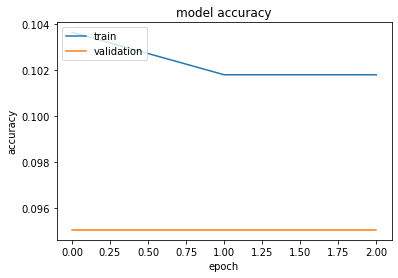

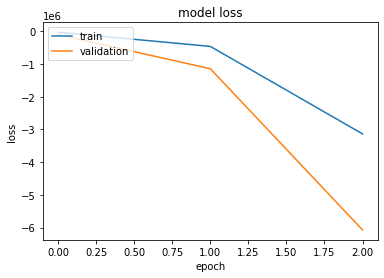


************* Execution times of each epoch **************
[3.5365138053894043, 2.196545124053955, 2.388335943222046]


In [53]:
print(history.history.keys())
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print("")
print("************* Execution times of each epoch **************")
print(times)

Hyperparameter tuning -- chnaging the batch size

In [13]:
print("Model building with chnaging batch size...")

model = Sequential()

model = Sequential()
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))

model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])


y = np.array(y)
model.fit(X, y, batch_size=8, epochs = 3, validation_split=0.2, callbacks=[time_callback])

Model building with chnaging batch size...
Epoch 1/3
947/947 [==============================] - 7s 7ms/step - loss: -871505.5500 - accuracy: 0.1009 - val_loss: -20318752.0000 - val_accuracy: 0.0961
Epoch 2/3
947/947 [==============================] - 6s 6ms/step - loss: -66903409.5654 - accuracy: 0.1071 - val_loss: -385864000.0000 - val_accuracy: 0.0961
Epoch 3/3
947/947 [==============================] - 6s 6ms/step - loss: -704285481.5865 - accuracy: 0.0949 - val_loss: -2116768256.0000 - val_accuracy: 0.0961


Hyperparameter training -- Dropout layer

In [16]:

print("Model building with adding dropout...")

model = Sequential()

model = Sequential()
model.add(Flatten(input_shape=X.shape[1:]))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.5))

model.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.6))

model.add(Dense(8, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dropout(0.7))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

y = np.array(y)
model.fit(X, y, batch_size=8, epochs = 3, validation_split=0.2, callbacks=[time_callback])

Model building with adding dropout...
Epoch 1/3
947/947 [==============================] - 7s 6ms/step - loss: -72518.2286 - accuracy: 0.1036 - val_loss: -2353880.5000 - val_accuracy: 0.0961
Epoch 2/3
947/947 [==============================] - 6s 6ms/step - loss: -9200877.0918 - accuracy: 0.1024 - val_loss: -59237672.0000 - val_accuracy: 0.0961
Epoch 3/3
947/947 [==============================] - 6s 6ms/step - loss: -113865729.1688 - accuracy: 0.1007 - val_loss: -347558336.0000 - val_accuracy: 0.0961
